In [1]:
push!(empty!(LOAD_PATH), "@")
using Pkg; Pkg.activate("../DistributedOptimization")

  Activating project at `~/Documents/Work/PhD 2A/julia_training/DiOp/DistributedOptimization`


In [2]:
using Distributed
n_workers = 10
nprocs()==1 || rmprocs(workers()); addprocs(n_workers);

In [3]:
@everywhere using Pkg
@everywhere Pkg.instantiate()
@everywhere Pkg.activate("../DistributedOptimization")

  Activating project at `~/Documents/Work/PhD 2A/julia_training/DiOp/DistributedOptimization`


      From worker 6:	  Activating project at `~/Documents/Work/PhD 2A/julia_training/DiOp/DistributedOptimization`
      From worker 8:	  Activating project at `~/Documents/Work/PhD 2A/julia_training/DiOp/DistributedOptimization`
      From worker 10:	  Activating project at `~/Documents/Work/PhD 2A/julia_training/DiOp/DistributedOptimization`
      From worker 2:	  Activating project at `~/Documents/Work/PhD 2A/julia_training/DiOp/DistributedOptimization`
      From worker 3:	  Activating project at `~/Documents/Work/PhD 2A/julia_training/DiOp/DistributedOptimization`
      From worker 9:	  Activating project at `~/Documents/Work/PhD 2A/julia_training/DiOp/DistributedOptimization`
      From worker 4:	  Activating project at `~/Documents/Work/PhD 2A/julia_training/DiOp/DistributedOptimization`
      From worker 11:	  Activating project at `~/Documents/Work/PhD 2A/julia_training/DiOp/DistributedOptimization`
      From worker 5:	  Activating project at `~/Documents/Work/PhD 2A/julia_tr

In [4]:
include("./src/DistributedOptimization.jl")

optimize (generic function with 2 methods)

In [5]:
using Distributed
using DistributedArrays

n,m = 50, 20
A = [@spawnat worker rand(n÷nworkers(),m) for worker in workers()]
A = reshape(A, :, 1)
A = DArray(A); # +

x_opt = rand(m,1)

b = [@spawnat worker A.localpart*x_opt + 0.01*rand(Poisson(1),(n÷nworkers(),1)) for worker in workers()]
b = reshape(b, :, 1)
b = DArray(b); # ++

λ = 0.001

objective = Objective(A,b,λ); # initializes worker_objective

x_init = rand(m,1); 

In [13]:
γ=1/objective.L;
paper_solver = PaperSolver(objective, γ); # initializes worker_solver

epochs = 1000; verbose = epochs÷10;
history_async_paper = optimize(x_init, epochs, paper_solver, verbose);

iterations = history_async_paper.iteration; verbose = iterations÷10;
history_sync_paper  = sync_optimize(x_init, iterations, paper_solver, verbose);

x_star_paper = history_sync_paper.logs["x"][end];

epoch=1, elapsed=0.0
epoch=100, elapsed=17.304854042
epoch=200, elapsed=18.0840125
epoch=300, elapsed=18.884633875
epoch=400, elapsed=19.641899584
epoch=500, elapsed=20.421887959
epoch=600, elapsed=21.232236709
epoch=700, elapsed=22.005964667
epoch=800, elapsed=22.783492084
epoch=900, elapsed=23.572712875
epoch=1000, elapsed=24.458773125
epoch=1, elapsed=0.0
epoch=10777, elapsed=18.00821725
epoch=21554, elapsed=34.930691
epoch=32331, elapsed=51.797247916
epoch=43108, elapsed=70.105769
epoch=53885, elapsed=89.551166416


In [14]:
γ=1/objective.L
piag_solver = PiagSolver(objective, γ); # initializes worker_solver

epochs = 1000; verbose = epochs÷10;
history_async_piag = optimize(x_init, epochs, piag_solver, verbose);

iterations=history_async_piag.iteration; verbose = iterations÷10;
history_sync_piag  = sync_optimize(x_init, iterations, piag_solver, verbose);

x_star_piag = history_sync_piag.logs["x"][end];

epoch=1, elapsed=0.0
epoch=100, elapsed=5.050897625
epoch=200, elapsed=5.894697333
epoch=300, elapsed=6.71695675
epoch=400, elapsed=7.548174333
epoch=500, elapsed=8.457202958
epoch=600, elapsed=9.325429291
epoch=700, elapsed=10.163820208
epoch=800, elapsed=10.985991458
epoch=900, elapsed=11.797811458
epoch=1000, elapsed=12.62401025
epoch=1, elapsed=0.0
epoch=5360, elapsed=9.979210916
epoch=10720, elapsed=20.184679125
epoch=16080, elapsed=30.233486875
epoch=21440, elapsed=39.269041375
epoch=26800, elapsed=48.143925166


In [15]:
# log!(history_async_paper, paper_objective.∇f)
# log!(history_sync_paper,  paper_objective.∇f)
# log!(history_async_piag, piag_objective.∇f)
# log!(history_sync_piag,  piag_objective.∇f)

## Plots

In [17]:
using LinearAlgebra

h(x) = sum(x.*log.(x))
∇h(x) = log.(x)
D(h,∇h,x,y) = h(x) - h(y) - ∇h(y)⋅(x-y)

D (generic function with 1 method)

### Plot algo synchrone

In [18]:
using Plots 
using LaTeXStrings
gr()

# p = "Time"
# p = "Epochs" 
p = "Iterations"

plot()
for (x_star, history, name) in zip([x_star_paper, x_star_piag],[history_sync_paper, history_sync_piag], ["sync_paper", "sync_piag"])
    if p=="Time"
        X = history.logs["elapsed"]
        Y = [D(h,∇h,x_star,x) for x in history.logs["x"]]
        plot!(X,Y,label=name)
    elseif p=="Epochs"
        Y = [D(h,∇h,x_star,x) for x in history.logs["x"]][history.logs["epochs"]]
        plot!(Y,label=name) 
    elseif p=="Iterations"
        Y = [D(h,∇h,x_star,x) for x in history.logs["x"]]
        plot!(Y,label=name) 
    end
end
    
xlabel!(p)
ylabel!(L"D_h(x_*,x_k)")

### Plots algo asynchrone

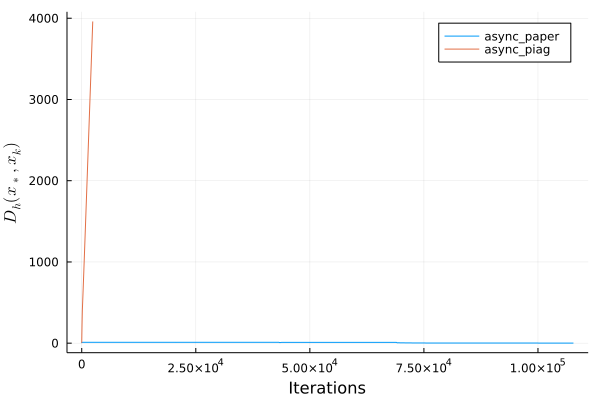

In [19]:
using Plots 
using LaTeXStrings
gr()

# p = "Time"
# p = "Epochs" 
p = "Iterations"

plot()
for (x_star, history, name) in zip([x_star_paper, x_star_piag],[history_async_paper, history_async_piag], ["async_paper", "async_piag"])
    if p=="Time"
        X = history.logs["elapsed"]
        Y = [D(h,∇h,x_star,x) for x in history.logs["x"]]
        plot!(X,Y,label=name)
    elseif p=="Epochs"
        Y = [D(h,∇h,x_star,x) for x in history.logs["x"]][history.logs["epochs"]]
        plot!(Y,label=name) 
    elseif p=="Iterations"
        Y = [D(h,∇h,x_star,x) for x in history.logs["x"]]
        plot!(Y,label=name) 
    end
end
    
xlabel!(p)
ylabel!(L"D_h(x_*,x_k)")

# display(plt)

- D_h(x*, xk) (10 000 epochs et ses iterations) n=10 `OK`
- Un prends 10x + de temps que les autres `OK`
- x* calculer avec 1 worker `OK`
- ajouter norm 1 `OK`
- ajouter piag
- compater sync async et piag
- mesure des iterations en temps cpu `OK`
- mesurer delay maximum


- Machine aléatoirement retardé ?

- Factoriser creation du problem `OK`

- tester map reduce travailleur `~OK`

Papier 


Illustration theoreme / D Bregman

vs

Comparaison piag / ||x-x*||